## Importing modules

In [44]:
from warnings import warn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# It's time to build a model

## Setting up a train-test split in scikit-learn

Alright, you've been patient and awesome. It's finally time to start training models!

The first step is to split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. We provide a function that will make sure at least <span style="color:blue">min_count</span> examples of each label appear in each split: <span style="color:blue">multilabel_train_test_split</span>. The code is below (obtained [here](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py)).

You'll start with a simple model that uses just the numeric columns of your DataFrame when calling multilabel_train_test_split. The data is loaded from a csv below and lists consisting of the dataframe's labels is available as LABELS and just the numeric columns is available as <span style="color:blue">NUMERIC_COLUMNS</span>.

In [16]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [21]:
# Import pandas
import pandas as pd

# Load the dataframe
df = pd.read_csv('ch2_df.csv', index_col=0)

# Define the column types
NUMERIC_COLUMNS = ['FTE', 'Total']
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

In [24]:
# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,label_dummies,size=0.2,seed=123, min_count=1)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 2 to 998
Data columns (total 2 columns):
FTE      800 non-null float64
Total    800 non-null float64
dtypes: float64(2)
memory usage: 18.8 KB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 999
Data columns (total 2 columns):
FTE      200 non-null float64
Total    200 non-null float64
dtypes: float64(2)
memory usage: 4.7 KB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 2 to 998
Columns: 113 entries, Function_'Aides Compensation' to Operating_Status_840: 'PreK-12 Operating'
dtypes: uint8(113)
memory usage: 94.5 KB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 999
Columns: 113 entries, Function_'Aides Compensation' to Operating_Status_840: 'PreK-12 Operating'
dtypes: uint8(113)
memory usage: 23.6 KB
None


## Side note: OneVsRest classification

The One Vs. Rest (also called One vs. All) approach to multiclass classification takes the approach of turning multiple classes into two binary classes then using logistic regression to calculate the probability that an observation, based on its features, belongs in that class as opposed to the aggregate, massed 'other' class. It cycles through the classes, doing this onevsall approach for each of them in turn (more detail [here:]( https://www.coursera.org/learn/machine-learning/lecture/68Pol/multiclass-classification-one-vs-all))

 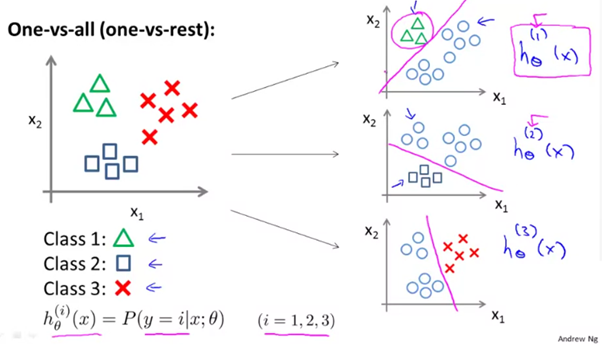

## Training a model

With split data in hand, you're only a few lines away from training a model.

In this exercise, you will import the logistic regression and one versus rest classifiers in order to fit a multi-class logistic regression model to the <span style="color:blue">NUMERIC_COLUMNS</span> of your feature data.

Then you'll test and print the accuracy with the <span style="color:blue">.score()</span> method to see the results of training.

__Before you train!__ Remember, we're ultimately going to be using logloss to score our model, so don't worry too much about the accuracy here. Keep in mind that you're throwing away all of the text data in the dataset - that's by far most of the data! So don't get your hopes up for a killer performance just yet. We're just interested in getting things up and running at the moment.

All data necessary to call <span style="color:blue">multilabel_train_test_split()</span> has been loaded into the workspace.

* [logistic_regression.score()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score)
* [sklearn.linear_model](http://scikit-learn.org/stable/modules/linear_model.html)
* [sklearn.multiclass](http://scikit-learn.org/stable/modules/multiclass.html)

In [25]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,label_dummies,size=0.2,seed=123, min_count=1)

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 37 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 46 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 52 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 66 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 92 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 10

Accuracy: 0.0


# Making predictions

## Use your model to predict values on holdout data

You're ready to make some predictions! Remember, the train-test-split you've carried out so far is for model development. The original competition provides an additional test set, for which you'll never actually see the correct labels. This is called the "holdout data."

The point of the holdout data is to provide a fair test for machine learning competitions. If the labels aren't known by anyone but DataCamp, DrivenData, or whoever is hosting the competition, you can be sure that no one submits a mere copy of labels to artificially pump up the performance on their model.

Remember that the original goal is to __predict the probability of each label__. In this exercise you'll do just that by using the <span style="color:blue">.predict_proba()</span> method on your trained model.

First, however, you'll need to load the holdout data, which is available in the workspace as the file HoldoutData.csv.

* [logistic_regression.predict_proba()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)

In [35]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit it to the training data
clf.fit(X_train, y_train)

# Load the holdout data: holdout
holdout = pd.read_csv('Holdout.csv', index_col=0)
 
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 37 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 46 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 52 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 66 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 92 is present in all training examples.
  str(classes[c]))
C:\Users\leero\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 10

## Writing out your results to a csv for submission

At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the <span style="color:blue">.to_csv()</span> method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the [correct format](https://www.drivendata.org/competitions/4/page/15/#sub_values).

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

__Interpreting LogLoss & Beating the Benchmark:__

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

Firstly, we generate a set of predictions - the probabilities of each observation belonging to a particular label. We then generate a dataframe by setting its index as being that of the holdout dataset, its columns as being the dummy columns of the dataframe we have been using in the above exercises, and the data as being the predictions generated above. So the dataframe is essentially a set of dummy labels and probabilities of each observation being in that label. 

* [df.columns](https://pandas.pydata.org/pandas-docs/stable/api.html#attributes-and-underlying-data)
* [df.index](https://pandas.pydata.org/pandas-docs/stable/api.html#attributes-and-underlying-data)
* [df.fillna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html)

In [ ]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns = pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)

# Save prediction_df to csv
prediction_df.to_csv('predictions.csv')

# Submit the predictions for scoring: score
score = score_submission(pred_path='predictions.csv')

# Print score
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

# A very brief introduction to NLP

## Tokenizing text

As we talked about in the video, [tokenization](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) is the process of chopping up a character sequence into pieces called tokens.

How do we determine what constitutes a token? Often, tokens are separated by whitespace. But we can specify other delimiters as well. For example, if we decided to tokenize on punctuation, then any punctuation mark would be treated like a whitespace. How we tokenize text in our DataFrame can affect the statistics we use in our model.

A particular cell in our budget DataFrame may have the string content <span style="color:blue">Title I - Disadvantaged Children/Targeted Assistance</span>. The number of n-grams generated by this text data is sensitive to whether or not we tokenize on punctuation, as you'll show in the following exercise.

How many tokens (1-grams) are in the string

    Title I - Disadvantaged Children/Targeted Assistance

if we tokenize on punctuation?

Answer: 6

## Testing your NLP credentials with n-grams

You're well on your way to NLP superiority. Let's test your mastery of n-grams!

In the workspace, we have the loaded a python list, <span style="color:blue">one_grams</span>, which contains all 1-grams of the string <span style="color:blue">petro-vend fuel and fluids</span>, tokenized on punctuation. Specifically,

    one_grams = ['petro', 'vend', 'fuel', 'and', 'fluids']

In this exercise, your job is to determine the sum of 1-grams, 2-grams and 3-grams generated by the string <span style="color:blue">petro-vend fuel and fluids</span>, tokenized on punctuation.

Recall that the n-gram of a sequence consists of all ordered subsequences of length n.

Answer: 12

In [34]:
one_grams = ['petro', 'vend', 'fuel', 'and', 'fluids']

# Representing text numerically

## Creating a bag-of-words in scikit-learn

In this exercise, you'll study the effects of tokenizing in different ways by comparing the bag-of-words representations resulting from different token patterns.

You will focus on one feature only, the <span style="color:blue">Position_Extra</span> column, which describes any additional information not captured by the <span style="color:blue">Position_Type</span> label.

For example, in the Shell you can check out the budget item in row 8960 of the data using <span style="color:blue">df.loc[8960]</span>. Looking at the output reveals that this <span style="color:blue">Object_Description</span> is overtime pay. For who? The Position Type is merely "other", but the Position Extra elaborates: "BUS DRIVER". Explore the column further to see more instances. It has a lot of NaN values.

Your task is to turn the raw text in this column into a bag-of-words representation by creating tokes that contain only alphanumeric characters.

For comparison purposes, the first 15 tokens of <span style="color:blue">vec_basic</span>, which splits <span style="color:blue">df.Position_Extra</span> into tokens when it encounters only whitespace characters, have been printed along with the length of the representation.

* [CountVectorizer()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (the token_pattern argument defines token separators)
* [CountVectorizer.fit()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit)

In [36]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 103 tokens in Position_Extra if we split on non-alpha numeric
['2nd', 'a', 'ab', 'additional', 'adm', 'administrative', 'and', 'any', 'art', 'assessment', 'assistant', 'asst', 'athletic', 'board', 'building']


Great work! Treating only alpha-numeric characters as tokens gives you a smaller number of more meaningful tokens. You've got bag-of-words in the bag!

## Combining text columns for tokenization

In order to get a bag-of-words representation for all of the text data in our DataFrame, you must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because you only looked at one column of data, so each row was already just a single string. <span style="color:blue">CountVectorizer</span> expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.

In this exercise, you'll complete the function definition <span style="color:blue">combine_text_columns()</span>. When completed, this function will convert all training text data in your DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the <span style="color:blue">.fit_transform()</span> method.

Note that the function uses <span style="color:blue">NUMERIC_COLUMNS</span> and <span style="color:blue">LABELS</span> to determine which columns to drop.

* [df.drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)
* [.tolist()](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.tolist.html)

In [37]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

## What's in a token?

Now you will use <span style="color:blue">combine_text_columns()</span> to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the <span style="color:blue">.fit_transform()</span> method.

You'll compare the effect of tokenizing using any non-whitespace characters as a token and using only alphanumeric characters as a token.

* [CountVectorizer.fit_transform()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [38]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 1685 tokens in the dataset
There are 780 alpha-numeric tokens in the dataset


## Appendix: Methods

* [logistic_regression.score()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score)
* [sklearn.linear_model](http://scikit-learn.org/stable/modules/linear_model.html)
* [sklearn.multiclass](http://scikit-learn.org/stable/modules/multiclass.html)
* [logistic_regression.predict_proba()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)
* [df.columns](https://pandas.pydata.org/pandas-docs/stable/api.html#attributes-and-underlying-data)
* [df.index](https://pandas.pydata.org/pandas-docs/stable/api.html#attributes-and-underlying-data)
* [df.fillna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html)
* [CountVectorizer()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [CountVectorizer.fit()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit)
* [df.drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)
* [.tolist()](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.tolist.html)
* [CountVectorizer.fit_transform()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)
